第一行文本： WM HOUSE, MC HOUSE 展览馆, 交通银行, 良品铺子
文本 hidden state shape: torch.Size([768])
图像样本数： 78575
图像原始特征维度： 1024
类别： ['Eh-1-1' 'Eh-1-2' 'Eh-1-3' 'Eh-1-4' 'Eh-10-1' 'Eh-10-2' 'Eh-10-3'
 'Eh-10-4' 'Eh-10-5' 'Eh-10-6' 'Eh-10-7' 'Eh-10-8' 'Eh-10-9' 'Eh-11-1'
 'Eh-11-2' 'Eh-11-3' 'Eh-11-4' 'Eh-12-1' 'Eh-12-2' 'Eh-12-3' 'Eh-12-4'
 'Eh-12-5' 'Eh-12-6' 'Eh-12-7' 'Eh-12-8' 'Eh-12-9' 'Eh-14-1' 'Eh-14-10'
 'Eh-14-2' 'Eh-14-3' 'Eh-14-4' 'Eh-14-5' 'Eh-14-6' 'Eh-14-7' 'Eh-14-8'
 'Eh-14-9' 'Eh-2-1' 'Eh-2-2' 'Eh-2-3' 'Eh-3-1' 'Eh-3-2' 'Eh-3-3' 'Eh-4-1'
 'Eh-5-1' 'Eh-5-2' 'Eh-6-1' 'Eh-6-2' 'Eh-7-1' 'Eh-7-2' 'Eh-7-3' 'Eh-8-1'
 'Eh-8-2' 'Eh-8-3' 'Eh-8-4' 'Eh-8-5' 'Eh-8-6' 'Eh-8-7' 'Eh-9-1' 'Eh-9-2'
 'Eh-9-3' 'Eh-9-4' 'Ev-1-1' 'Ev-1-2' 'Ev-1-3' 'Ev-1-4' 'Ev-1-5' 'Ev-1-6'
 'Ev-1-7' 'Ev-1-8' 'Ev-10-1' 'Ev-10-10' 'Ev-10-2' 'Ev-10-3' 'Ev-10-4'
 'Ev-10-5' 'Ev-10-6' 'Ev-10-7' 'Ev-10-8' 'Ev-10-9' 'Ev-11-1' 'Ev-11-2'
 'Ev-11-3' 'Ev-12-1' 'Ev-12-2' 'Ev-13-1' 'Ev-2-1' 'Ev-2-2' 'Ev-2-3'
 'Ev-2-4' 'Ev-2-5' 'Ev-2-6' 'Ev

C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\17531\.conda\envs\torch_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-77

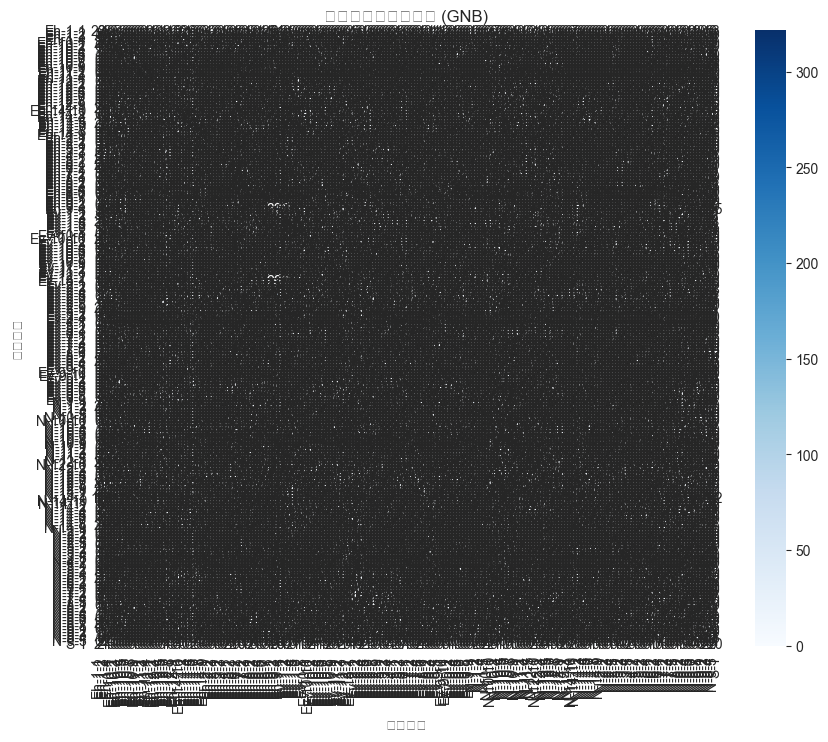

In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

###############################################
# 1. Text prior: obtain hidden state of first Excel row via BERT
###############################################
# Update text_data_path to your Excel file path
text_data_path = 'Final Dataset-Texts.xlsx'
df_text = pd.read_excel(text_data_path)
# Take the first row of the “List of Store Names” column (as the text vector for the first label)
first_text = df_text['List of Store Names'].iloc[0]
print("First row text:", first_text)

# Use a pre-trained BERT model (e.g., bert-base-chinese if the text is Chinese)
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
bert_model = BertModel.from_pretrained("bert-base-chinese")
bert_model.eval()  # freeze BERT parameters
with torch.no_grad():
    inputs = tokenizer(first_text, return_tensors="pt", truncation=True, padding=True)
    outputs = bert_model(**inputs)
    # Take the [CLS] token hidden state, shape (1, 768)
    text_hidden_state = outputs.last_hidden_state[:, 0, :]
    text_hidden_state = text_hidden_state.squeeze(0)  # becomes (768,)
print("Text hidden state shape:", text_hidden_state.shape)

###############################################
# 2. Image loading and preprocessing
###############################################
# Update img_data_dir to your image dataset folder path
# Assume each subfolder name is the class label
img_data_dir = '../all'

image_features = []    # raw image features (1024 dims)
labels = []            # class labels (strings)

for class_name in os.listdir(img_data_dir):
    class_path = os.path.join(img_data_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                try:
                    img = Image.open(os.path.join(class_path, filename))
                    img = img.convert('L')        # convert to grayscale
                    img = img.resize((32, 32))    # resize to 32×32
                    img_array = np.array(img).flatten()  # flatten to 1024-dim vector
                    image_features.append(img_array)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error reading {os.path.join(class_path, filename)}:", e)

# Convert to NumPy arrays and normalize to [0, 1]
image_features = np.array(image_features, dtype='float32') / 255.0
labels = np.array(labels)
print("Number of image samples:", image_features.shape[0])
print("Original image feature dimension:", image_features.shape[1])
print("Classes:", np.unique(labels))

###############################################
# 3. Split into training and test sets
###############################################
X_train, X_test, y_train, y_test = train_test_split(
    image_features, labels, test_size=0.5, random_state=42, stratify=labels
)
print("Training samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

###############################################
# 4. Dimensionality reduction on image features (PCA)
###############################################
# Reduce image features to 128 dimensions
pca = PCA(n_components=128)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced  = pca.transform(X_test)
print("Reduced training feature dimension:", X_train_reduced.shape[1])

###############################################
# 5. Multimodal feature construction: concatenate image features with text prior
###############################################
# The text prior is the fixed 768-dim vector obtained from BERT.
# For each sample, concatenate the reduced image feature with the text vector.
def fuse_features(X, text_vector):
    # X: (n_samples, d_image), text_vector: (d_text,)
    n_samples = X.shape[0]
    text_expanded = np.tile(text_vector.cpu().numpy(), (n_samples, 1))  # (n_samples, 768)
    fused = np.concatenate([X, text_expanded], axis=1)  # e.g., (n_samples, 128+768=896)
    return fused

fused_train = fuse_features(X_train_reduced, text_hidden_state)
fused_test  = fuse_features(X_test_reduced, text_hidden_state)
print("Fused feature dimension:", fused_train.shape[1])

###############################################
# 6. Train Gaussian Naive Bayes model
###############################################
gnb = GaussianNB()
gnb.fit(fused_train, y_train)
y_pred = gnb.predict(fused_test)

acc = accuracy_score(y_test, y_pred)
print("Test set accuracy:", acc)
print("Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Multimodal Model Confusion Matrix (GNB)")
plt.show()
